# Iris eye Recognition

## Firstly, we will import all required libraries

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random as rd
import math
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
import time

## Then let's have a look into the datasets

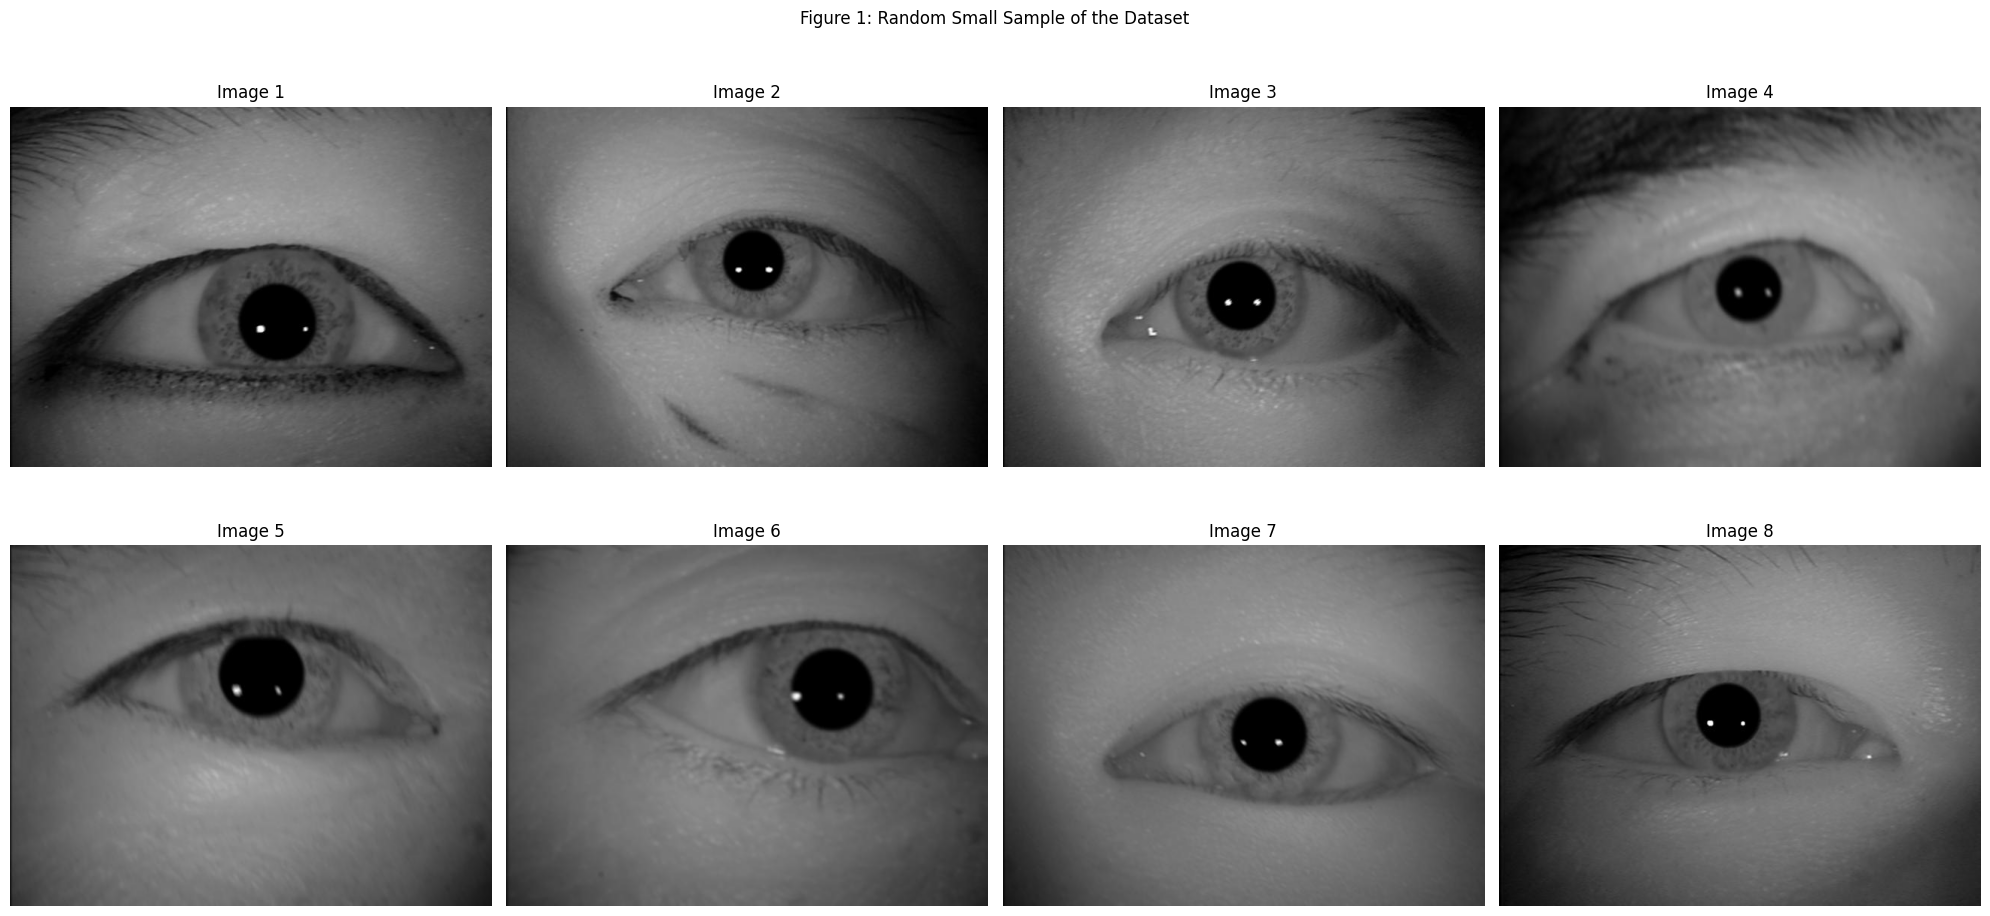

In [6]:
def show_random_samples(dataset_dir, num):
    # Get all image paths in the dataset directory
    image_paths = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".jpg"):  # Adjust if you have a different image format
                image_paths.append(os.path.join(root, file))
    
    # Randomly select 'num' images
    rd.seed(1190652)
    random_indices = rd.sample(range(len(image_paths)), num)
    
    # Determine the number of rows for subplots (4 images per row)
    num_rows = math.ceil(num / 4)
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))
    
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        
        # Load and display the image
        image_path = image_paths[idx]
        image = Image.open(image_path)
        image_rgb = image.convert("RGB")
        
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image_rgb)
        ax.set_title(f"Image {i + 1}")
        ax.axis("off")

    plt.suptitle("Figure 1: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

# Example usage
dataset_dir = r'dataset'  
show_random_samples(dataset_dir, 8)

- Some eyes uses eyeliner.
- Some eyes interval are big.
- Some eyes intervals are small.
- The images are greyscaled.

## I)Localization


### Gaussian and Bilateral Filter are mostly used for enhancing image for iris detection, so we will try these first

### 1) Gaussian

Firstly, we will use Gaussian Blur to smooth out the image and remove high-frequency noise that might interfere with Hough Circle Detection

In [7]:

def localization_Gauss(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_blurred = cv2.GaussianBlur(gray, (5, 5), 2)
        circles = cv2.HoughCircles(
            gray_blurred,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    


For the multiple processing at a time, I will use a loop function to looping through all 10000 images in the datasets

In [8]:
def iterate_dataset_localization(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_Gauss(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389


Quite a good output though, only failed 4.5%

Let's have a look at those error images.

Image 1 size: (640, 480), Mode: RGB
Image 2 size: (640, 480), Mode: RGB
Image 3 size: (640, 480), Mode: RGB
Image 4 size: (640, 480), Mode: RGB
Image 5 size: (640, 480), Mode: RGB


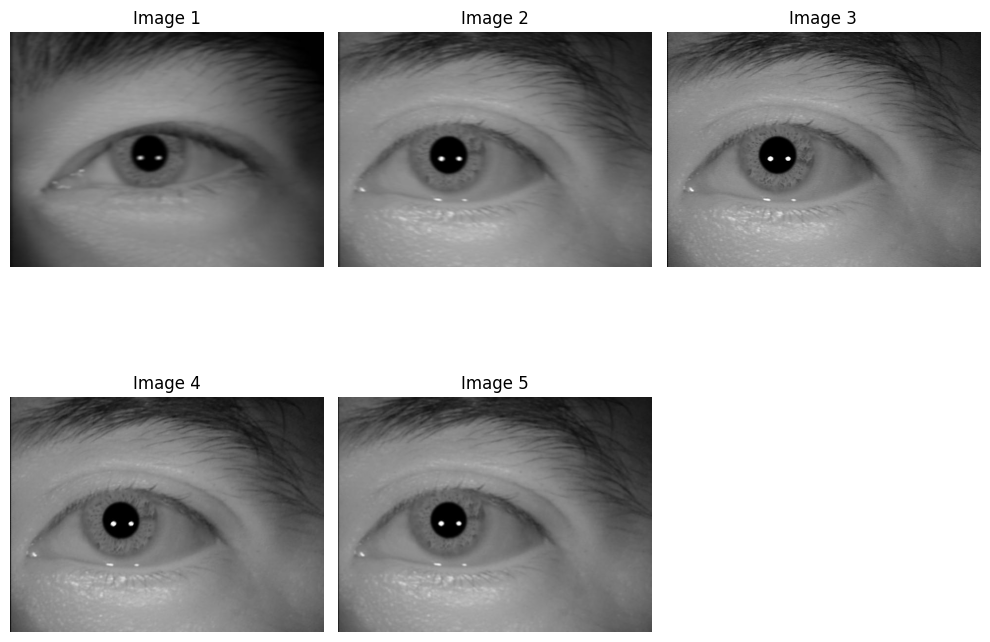

In [9]:
image_paths = [
    r'dataset\019\S6019S07.jpg',
    r'dataset\021\S6021S03.jpg',
    r'dataset\021\S6021S05.jpg',
    r'dataset\021\S6021S08.jpg',
    r'dataset\021\S6021S09.jpg'
]

# Create a figure to display multiple images
plt.figure(figsize=(10, 8))

# Loop through each image path and display the image
for i, image_path in enumerate(image_paths, 1):
    # Open the image using PIL
    try:
        image = Image.open(image_path)
        
        # Check if the image is in RGBA or another mode and convert it to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
    except Exception as e:
        print(f"Failed to load image at: {image_path}. Error: {e}")
        continue

    # Debugging: Check the image mode and size
    print(f"Image {i} size: {image.size}, Mode: {image.mode}")  # Should be RGB for color images

    # Add the image to the subplot
    plt.subplot(2, 3, i)  # 2 rows, 3 columns, i-th image
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title(f"Image {i}")

# Display the images
plt.tight_layout()
plt.show()

These images mostly being blurred by the quality of the sensors, so I will try apply multiple image processing method to improve the quality. We will try some combination of image processing method instead of using only one like this

### 2)Multiple combination
#### a)CLAHE + Gaussian Blur:

In [10]:

def localization_Gauss_CLAHE(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 2)
        gray_blurred = cv2.equalizeHist(blurred)
        
        circles = cv2.HoughCircles(
            gray_blurred,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    

Then we iterate through the dataset 1 more time

In [11]:
def iterate_dataset_localization_Gauss_CLAHE(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_Gauss_CLAHE(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization_Gauss_CLAHE(dataset_path)

Error files: 
dataset\318\S6318S01.jpg
dataset\318\S6318S02.jpg
dataset\318\S6318S04.jpg
dataset\358\S6358S07.jpg
dataset\574\S6574S09.jpg
Number of images: 10000
Number of errors: 14


The result is even worst 

#### b)Sharpening filter

In [12]:

def localization_sharpening_filter(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sharpening_kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])

        gray_sharpened= cv2.filter2D(gray, -1, sharpening_kernel)
        blurred = cv2.GaussianBlur(gray_sharpened, (5, 5), 2)
        
        
        circles = cv2.HoughCircles(
            blurred,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    

Let's iterate through the dataset one more time

In [13]:
def iterate_dataset_localization_sharpening(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_sharpening_filter(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization_sharpening(dataset_path)

Error files: 
dataset\019\S6019S04.jpg
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\022\S6022S04.jpg
dataset\022\S6022S07.jpg
Number of images: 10000
Number of errors: 272


Still bad performance, let's try another one

#### c)Histogram Equalization + Gaussian Blur

In [14]:

def localization_HisEqualGauss(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 2)
        equalized = cv2.equalizeHist(blurred)
        
        
        circles = cv2.HoughCircles(
            equalized,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    

In [15]:
def iterate_dataset_localization_HisEquaL_Gauss(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_HisEqualGauss(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization_HisEquaL_Gauss(dataset_path)

Error files: 
dataset\318\S6318S01.jpg
dataset\318\S6318S02.jpg
dataset\318\S6318S04.jpg
dataset\358\S6358S07.jpg
dataset\574\S6574S09.jpg
Number of images: 10000
Number of errors: 14


##### After several tries, the Gaussian method to improving the recognition of Iris using Hough Circle gives the best performance. Let's moving on to normalization step.

Result:

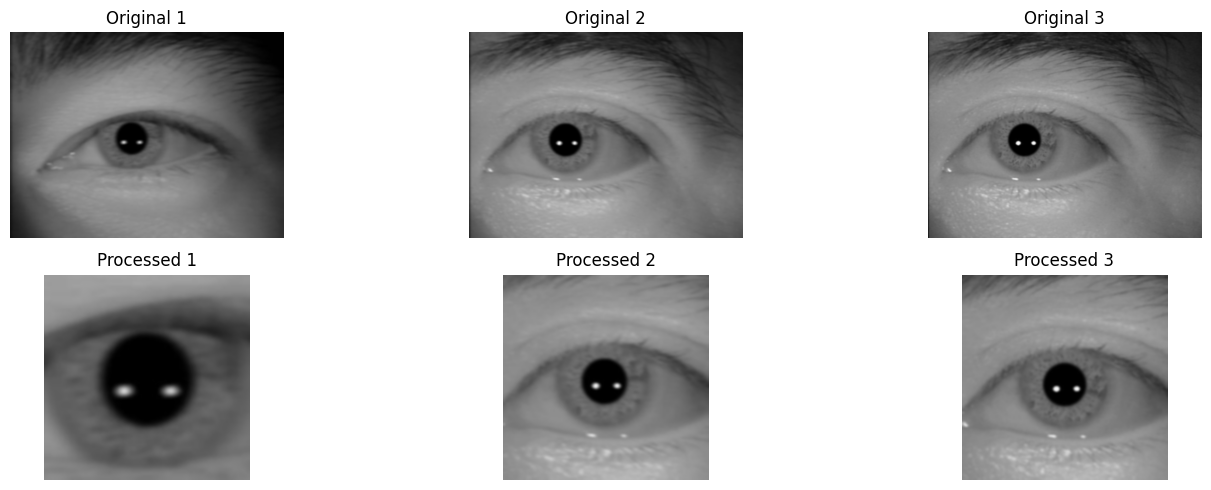

In [16]:
def load_and_process_image(image_path):
    image = cv2.imread(image_path)
    if image is None: 
        print(f"Error loading image: {image_path}")
        return None
    return cv2.cvtColor(cv2.GaussianBlur(image, (5, 5), 0), cv2.COLOR_BGR2RGB)

def display_images(non_processed_paths, processed_paths):
    plt.figure(figsize=(15, 5))
    for i, (orig_path, proc_path) in enumerate(zip(non_processed_paths, processed_paths)):
        orig_image, proc_image = load_and_process_image(orig_path), load_and_process_image(proc_path)
        if orig_image is None or proc_image is None:
            continue
        # Display original and processed images in subplots
        plt.subplot(2, len(non_processed_paths), i + 1)
        plt.imshow(orig_image), plt.axis('off'), plt.title(f"Original {i+1}")
        plt.subplot(2, len(non_processed_paths), len(non_processed_paths) + i + 1)
        plt.imshow(proc_image), plt.axis('off'), plt.title(f"Processed {i+1}")
    plt.tight_layout()
    plt.show()

# Example usage
non_processed_paths = [
    r'dataset\019\S6019S07.jpg', 
    r'dataset\021\S6021S03.jpg',
    r'dataset\021\S6021S05.jpg'
]

processed_paths = [
    r'processed_image\019\S6019S07.jpg',  
    r'processed_image\021\S6021S03.jpg',
    r'processed_image\021\S6021S05.jpg'
]

# Display the images
display_images(non_processed_paths, processed_paths)

## II)Normalization

### 1)Histogram Equalization

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389


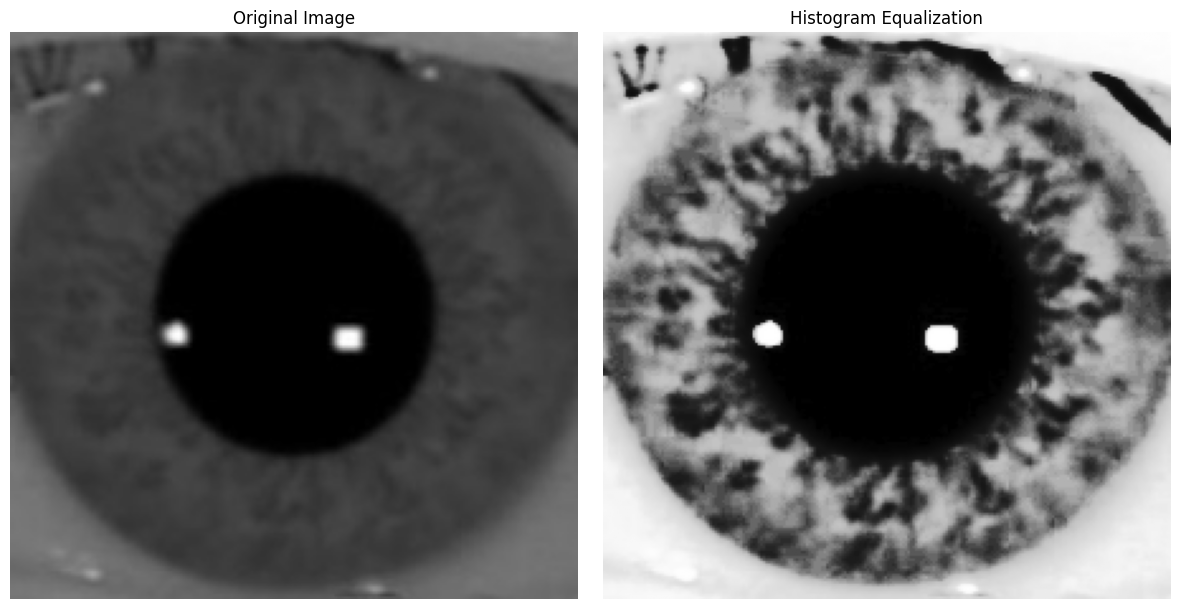

In [21]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
def funHistogramEqualization(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray)
    equalized_image_normalized = equalized_image
    return equalized_image_normalized
image_path = r"processed_image\000\S6000S07.jpg"
original_image = cv2.imread(image_path)

# Apply the histogram equalization function
equalized_image = funHistogramEqualization(original_image)

# Display original and equalized images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Equalized image
plt.subplot(1, 2, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title("Histogram Equalization")
plt.axis("off")

plt.tight_layout()
plt.show()


### 2)CLAHE:


Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389


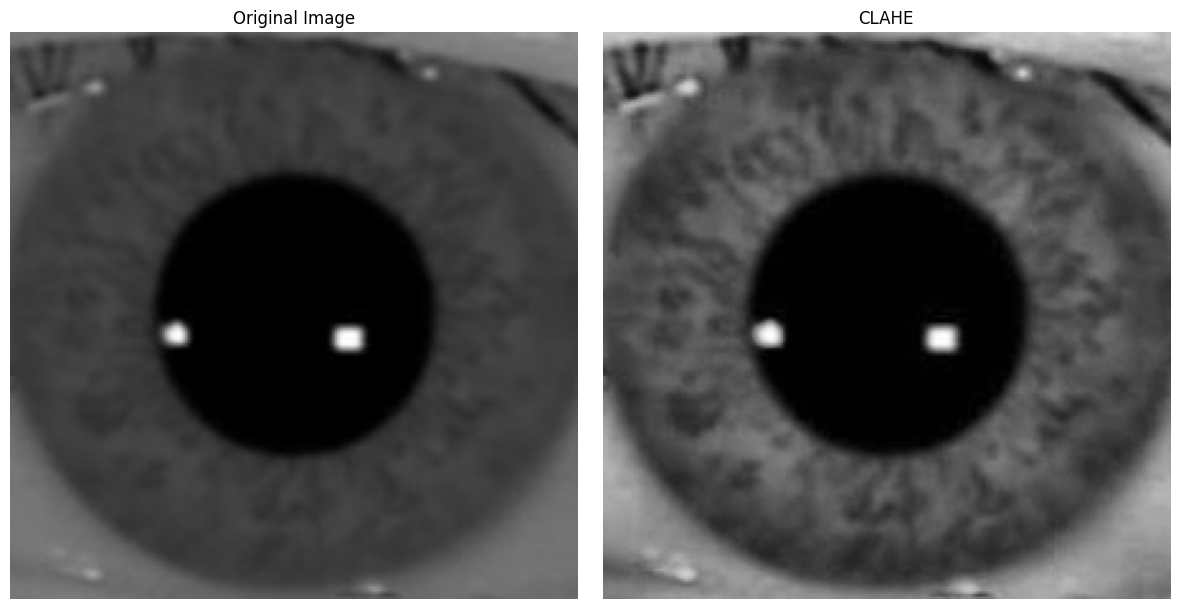

In [22]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
def CLAHE(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray)
    return clahe_image
image_path = r"processed_image\000\S6000S07.jpg"
original_image = cv2.imread(image_path)

# Apply the histogram equalization function
equalized_image = CLAHE(original_image)

# Display original and equalized images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Equalized image
plt.subplot(1, 2, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title("CLAHE")
plt.axis("off")

plt.tight_layout()
plt.show()


### 3)Gamma correction:

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389


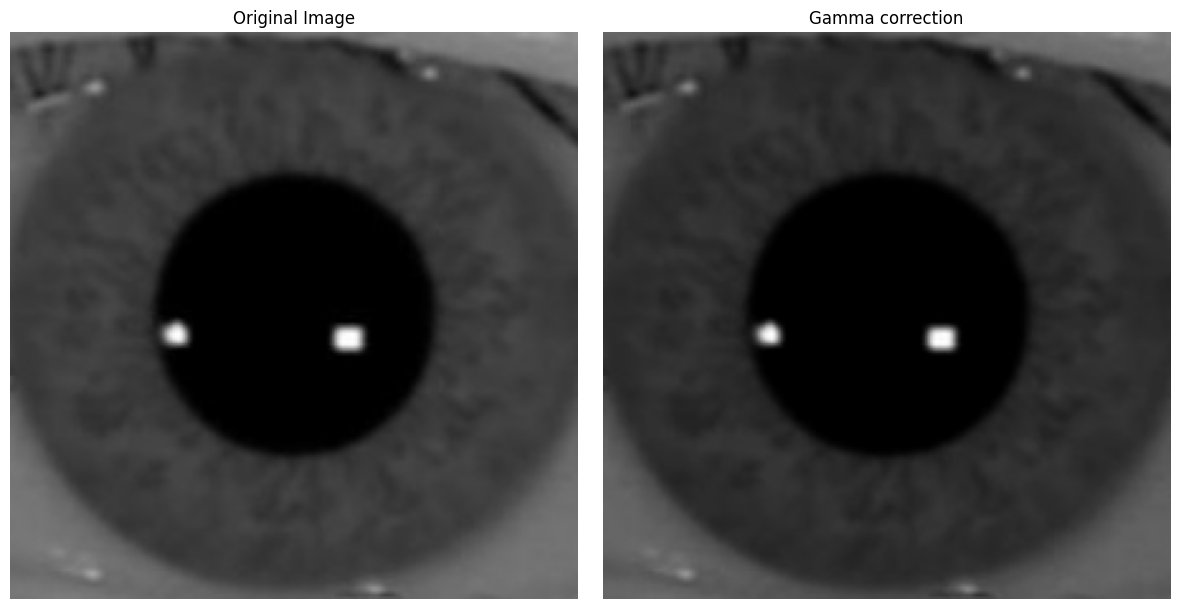

In [23]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
def gamma_correction(image, gamma=1.2):
    # Normalize the image to [0, 1]
    image_normalized = image / 255.0
    # Apply gamma correction
    image_corrected = np.power(image_normalized, gamma)
    return np.uint8(image_corrected * 255)
image_path = r"processed_image\000\S6000S07.jpg"
original_image = cv2.imread(image_path)

# Apply the histogram equalization function
equalized_image = gamma_correction(original_image)

# Display original and equalized images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Equalized image
plt.subplot(1, 2, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title("Gamma correction")
plt.axis("off")

plt.tight_layout()
plt.show()



### 4)Constrast Stretching

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389


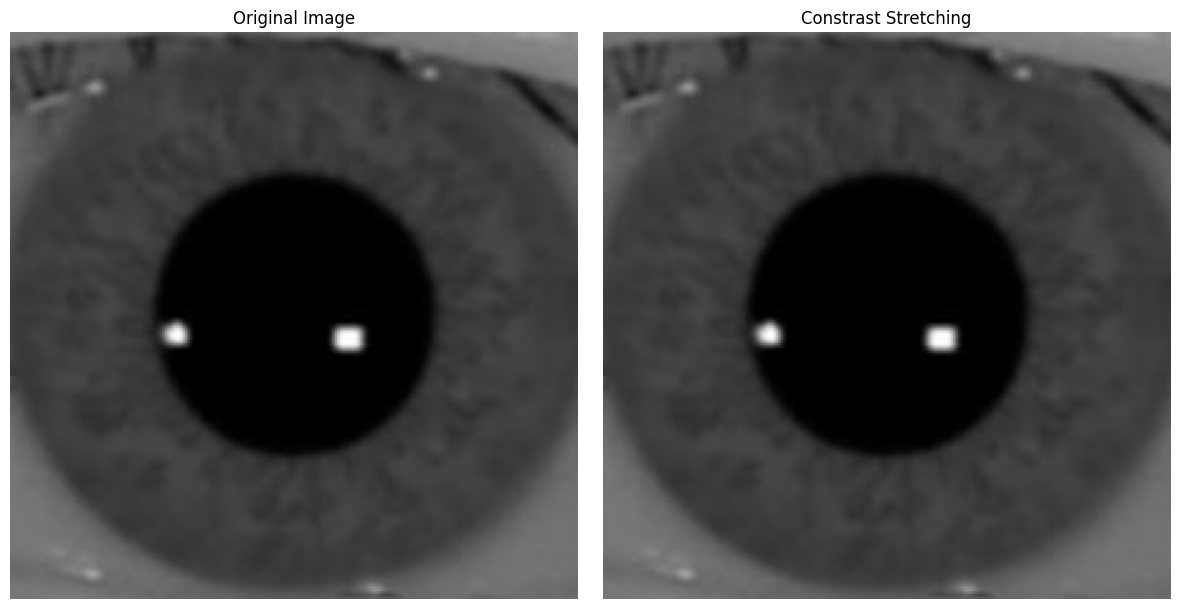

In [24]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
def contrast_stretching(image):
    # Normalize the image
    min_val = np.min(image)
    max_val = np.max(image)
    # Apply contrast stretching
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return np.uint8(stretched_image)
image_path = r"processed_image\000\S6000S07.jpg"
original_image = cv2.imread(image_path)

# Apply the histogram equalization function
equalized_image = contrast_stretching(original_image)

# Display original and equalized images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Equalized image
plt.subplot(1, 2, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title("Constrast Stretching")
plt.axis("off")

plt.tight_layout()
plt.show()

## III)Feature Selection

### 1)Haar Wavelet:

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389
Displaying results for: S6000S00.jpg


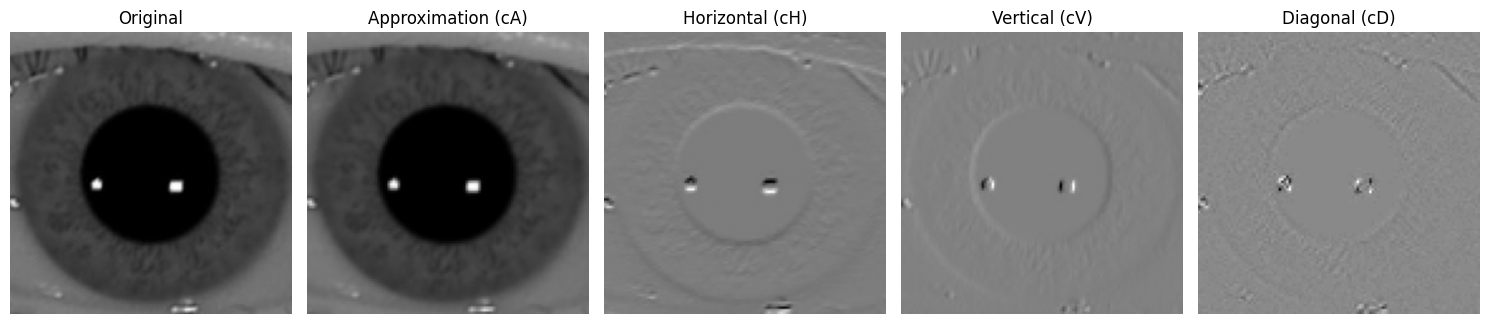

Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S00
Displaying results for: S6000S01.jpg


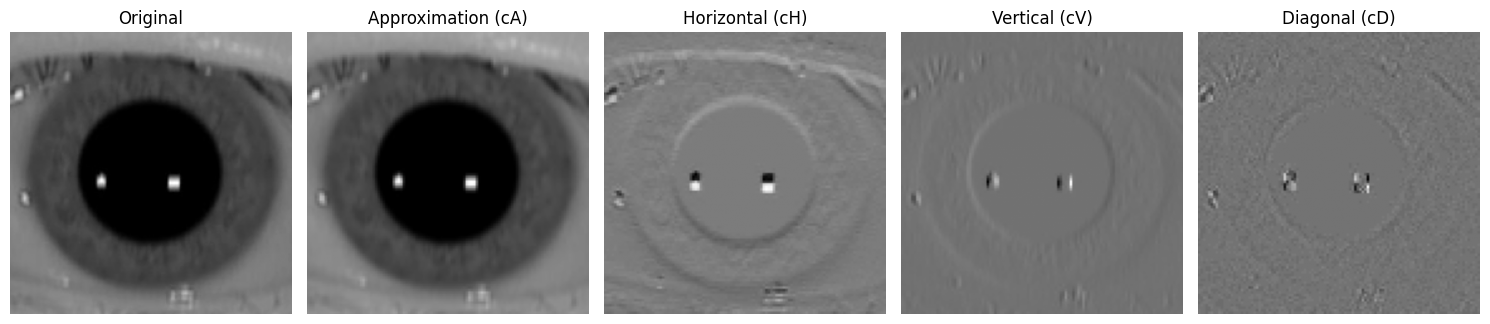

Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S01


In [27]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
import pywt

def haar_wavelet_transform(image):
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    return cA, cH, cV, cD

def display_images(original_image, cA, cH, cV, cD):
    """Display the original image and the 4 processed wavelet images."""
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 5, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Approximation (cA)
    plt.subplot(1, 5, 2)
    plt.imshow(cA, cmap='gray')
    plt.title("Approximation (cA)")
    plt.axis("off")

    # Horizontal detail (cH)
    plt.subplot(1, 5, 3)
    plt.imshow(cH, cmap='gray')
    plt.title("Horizontal (cH)")
    plt.axis("off")

    # Vertical detail (cV)
    plt.subplot(1, 5, 4)
    plt.imshow(cV, cmap='gray')
    plt.title("Vertical (cV)")
    plt.axis("off")

    # Diagonal detail (cD)
    plt.subplot(1, 5, 5)
    plt.imshow(cD, cmap='gray')
    plt.title("Diagonal (cD)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def process_and_save_images(base_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    processed_count = 0  # Counter to track processed images

    for folder_index in range(1):  # Limiting to the first folder for simplicity
        folder_name = f"{base_folder}/{folder_index:03d}"
        if not os.path.exists(folder_name):
            continue

        for image_name in os.listdir(folder_name):
            if processed_count >= 2:  # Stop after processing 2 images
                return

            image_path = os.path.join(folder_name, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                continue

            # Load the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            # Apply Haar wavelet transform
            cA, cH, cV, cD = haar_wavelet_transform(image)

            # Display images
            print(f"Displaying results for: {image_name}")
            display_images(image, cA, cH, cV, cD)

            # Save processed images
            image_base_name = os.path.splitext(image_name)[0]
            output_subfolder = os.path.join(output_folder, f"{folder_index:03d}", image_base_name)
            os.makedirs(output_subfolder, exist_ok=True)

            plt.imsave(f"{output_subfolder}/cA.jpg", cA, cmap='gray')
            plt.imsave(f"{output_subfolder}/cH.jpg", cH, cmap='gray')
            plt.imsave(f"{output_subfolder}/cV.jpg", cV, cmap='gray')
            plt.imsave(f"{output_subfolder}/cD.jpg", cD, cmap='gray')

            print(f"Processed and saved: {output_subfolder}")

            processed_count += 1  # Increment the processed image count

# Paths for input and output
script_dir = os.getcwd()  # Use current working directory for Jupyter
base_folder = os.path.join(script_dir, "processed_image")  # Update path accordingly
output_folder = os.path.join(script_dir, "feature_image/gabor_filter")

# Process and display images
process_and_save_images(base_folder, output_folder)


### 2)Laplacian:

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389
Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S00.jpg
Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S01.jpg


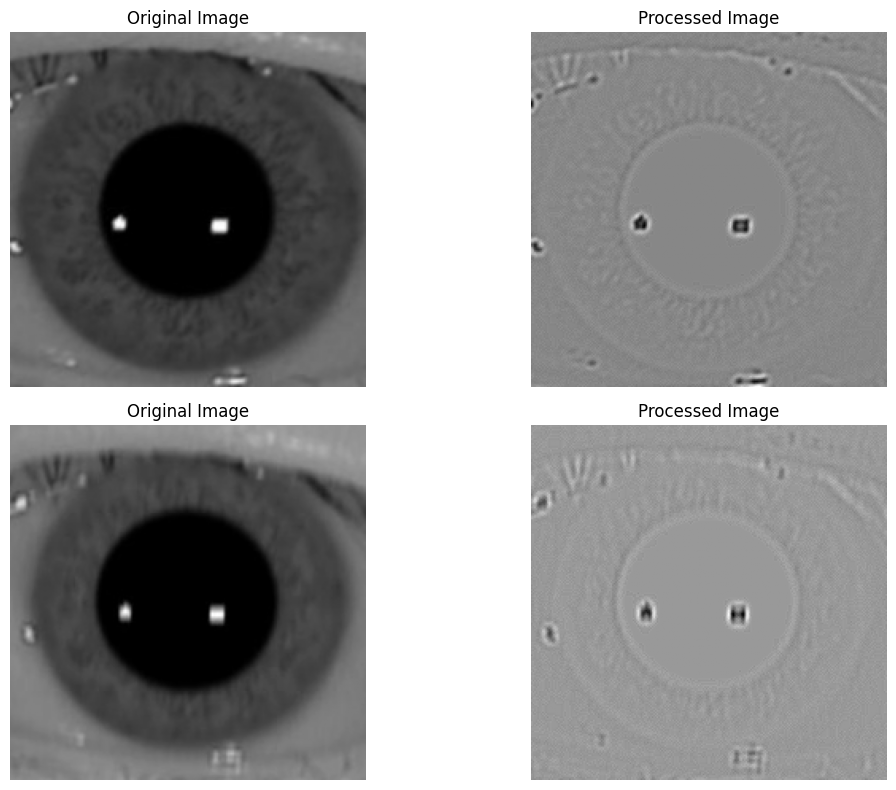

In [28]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)

def laplacian_of_gaussian(image, ksize=5, sigma=1.0):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), sigma)
    log_image = cv2.Laplacian(blurred, cv2.CV_64F)
    return log_image

def plot_image_pairs(original_images, processed_images):
    """Plot original and processed images side by side."""
    pairs = zip(original_images, processed_images)
    plt.figure(figsize=(12, 8))

    for i, (original, processed) in enumerate(pairs):
        plt.subplot(2, 2, i * 2 + 1)
        plt.imshow(original, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(2, 2, i * 2 + 2)
        plt.imshow(processed, cmap="gray")
        plt.title("Processed Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def process_and_save_log_images(base_folder, output_folder, ksize=5, sigma=1.0):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    original_images = []
    processed_images = []

    for folder_index in range(1000):
        folder_name = f"{base_folder}/{folder_index:03d}"
        if not os.path.exists(folder_name):
            continue

        output_subfolder = os.path.join(output_folder, f"{folder_index:03d}")
        os.makedirs(output_subfolder, exist_ok=True)

        for image_name in os.listdir(folder_name):
            image_path = os.path.join(folder_name, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                continue

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            log_result = laplacian_of_gaussian(image, ksize, sigma)

            # Save processed image
            output_image_name = os.path.splitext(image_name)[0] + ".jpg"
            output_image_path = os.path.join(output_subfolder, output_image_name)
            cv2.imwrite(output_image_path, log_result)

            print(f"Processed and saved: {output_image_path}")

            # Store for visualization
            if len(original_images) < 2:  # Limit to 2 pairs
                original_images.append(image)
                processed_images.append(log_result)

            # Display images once we have 2 pairs
            if len(original_images) == 2:
                plot_image_pairs(original_images, processed_images)
                return  # Stop after processing and plotting 2 pairs

def main():
    script_dir = os.getcwd()  # Current working directory for Jupyter
    base_folder = os.path.join(script_dir, "processed_image")
    output_folder = os.path.join(script_dir, "feature_image/gabor_filter")
    process_and_save_log_images(base_folder, output_folder, ksize=5, sigma=1.0)

if __name__ == "__main__":
    main()


### 3)Log Gabor

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389
Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S00.jpg
Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S01.jpg


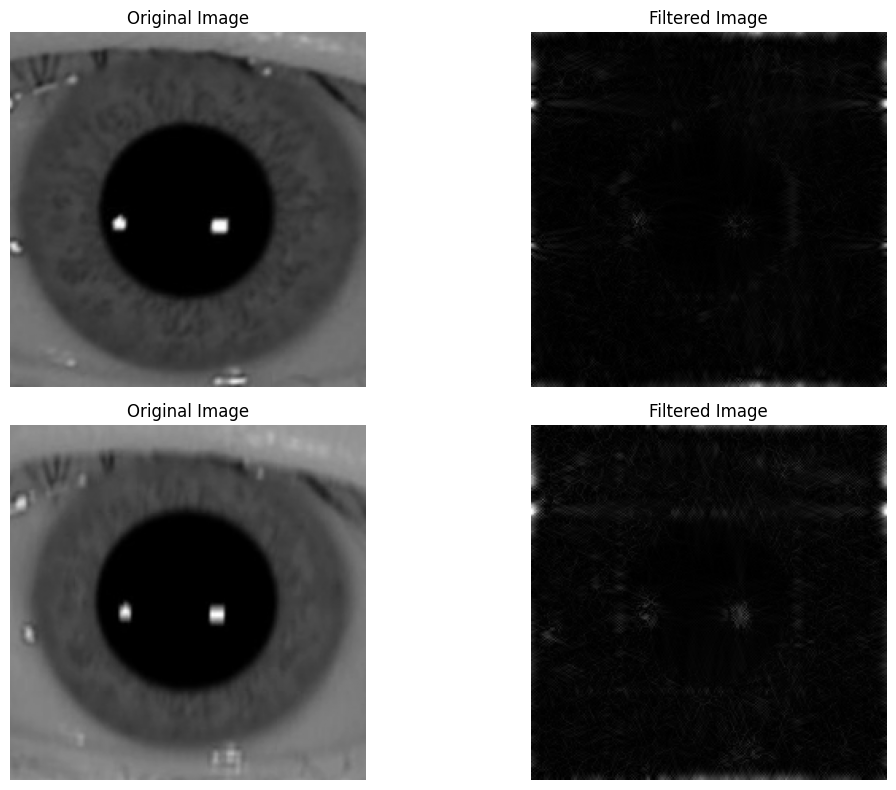

In [29]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
def log_gabor_filter(shape, wavelength, sigma_on_f):
    rows, cols = shape
    x = np.linspace(-0.5, 0.5, cols)
    y = np.linspace(-0.5, 0.5, rows)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt(X ** 2 + Y ** 2)
    radius[rows // 2, cols // 2] = 1  # Avoid division by zero
    log_radius = np.log(radius / wavelength)
    log_gabor = np.exp(-(log_radius ** 2) / (2 * np.log(sigma_on_f) ** 2))
    log_gabor[radius > 0.5] = 0  # Remove high frequencies
    return log_gabor


def apply_log_gabor(image, log_gabor_filter):
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    filtered_fft = fft_image * log_gabor_filter
    filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))
    return filtered_image


def plot_image_pairs(original_images, filtered_images):
    """Plot two pairs of images (original and processed)."""
    plt.figure(figsize=(12, 8))

    for i, (original, filtered) in enumerate(zip(original_images, filtered_images)):
        # Original image
        plt.subplot(2, 2, i * 2 + 1)
        plt.imshow(original, cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Filtered image
        plt.subplot(2, 2, i * 2 + 2)
        plt.imshow(filtered, cmap='gray')
        plt.title("Filtered Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def process_and_save_log_gabor(base_folder, output_folder, wavelength=10, sigma_on_f=0.56):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    original_images = []
    filtered_images = []

    for folder_index in range(1000):
        folder_name = f"{base_folder}/{folder_index:03d}"
        if not os.path.exists(folder_name):
            continue

        output_subfolder = os.path.join(output_folder, f"{folder_index:03d}")
        os.makedirs(output_subfolder, exist_ok=True)

        for image_name in os.listdir(folder_name):
            image_path = os.path.join(folder_name, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                continue

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            log_gabor = log_gabor_filter(image.shape, wavelength, sigma_on_f)
            filtered_image = apply_log_gabor(image, log_gabor)

            output_image_name = os.path.splitext(image_name)[0] + ".jpg"
            output_image_path = os.path.join(output_subfolder, output_image_name)
            cv2.imwrite(output_image_path, (filtered_image * 255).astype(np.uint8))

            print(f"Processed and saved: {output_image_path}")

            # Collect images for visualization
            if len(original_images) < 2:  # Limit to 2 pairs
                original_images.append(image)
                filtered_images.append(filtered_image)

            # Stop processing after visualizing 2 pairs
            if len(original_images) == 2:
                plot_image_pairs(original_images, filtered_images)
                return


def main():
    script_dir = os.getcwd()  # Use current working directory for Jupyter
    base_folder = os.path.join(script_dir, "processed_image")
    output_folder = os.path.join(script_dir, "feature_image/gabor_filter")
    process_and_save_log_gabor(base_folder, output_folder, wavelength=10, sigma_on_f=0.56)


if __name__ == "__main__":
    main()

### 4)Gabor

Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
dataset\022\S6022S04.jpg
Number of images: 10000
Number of errors: 389
Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S00.jpg
Processed and saved: F:\Project\Iris\iris-authentication\feature_image/gabor_filter\000\S6000S01.jpg


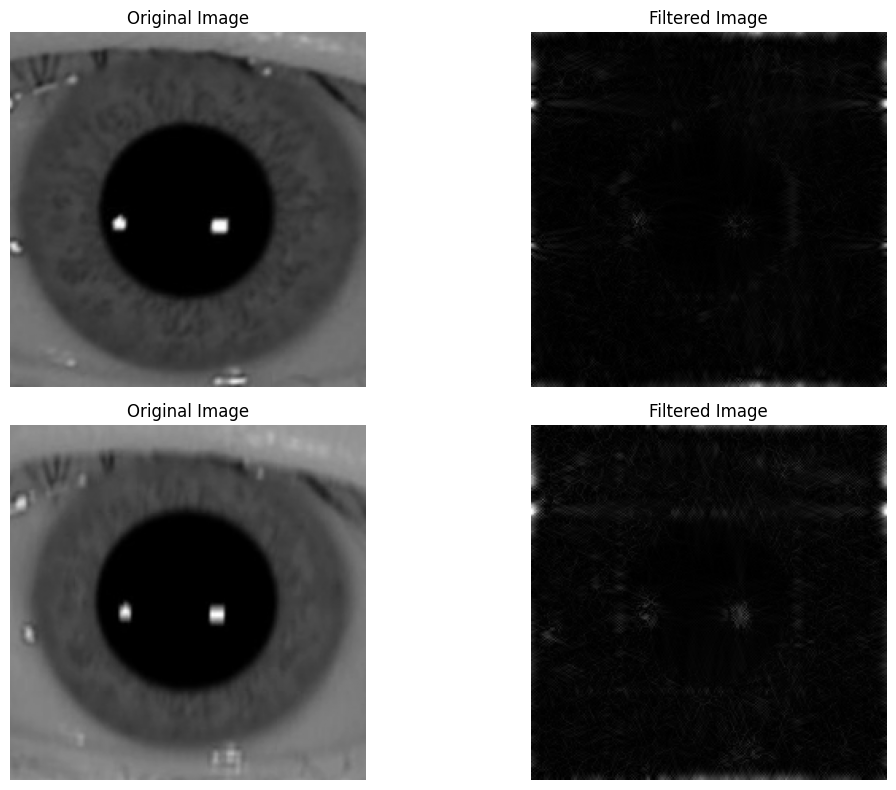

In [30]:
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)
def log_gabor_filter(shape, wavelength, sigma_on_f):
    rows, cols = shape
    x = np.linspace(-0.5, 0.5, cols)
    y = np.linspace(-0.5, 0.5, rows)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt(X ** 2 + Y ** 2)
    radius[rows // 2, cols // 2] = 1  # Avoid division by zero
    log_radius = np.log(radius / wavelength)
    log_gabor = np.exp(-(log_radius ** 2) / (2 * np.log(sigma_on_f) ** 2))
    log_gabor[radius > 0.5] = 0  # Remove high frequencies
    return log_gabor


def apply_log_gabor(image, log_gabor_filter):
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    filtered_fft = fft_image * log_gabor_filter
    filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))
    return filtered_image


def plot_image_pairs(original_images, filtered_images):
    """Plot two pairs of images (original and processed)."""
    plt.figure(figsize=(12, 8))

    for i, (original, filtered) in enumerate(zip(original_images, filtered_images)):
        # Original image
        plt.subplot(2, 2, i * 2 + 1)
        plt.imshow(original, cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Filtered image
        plt.subplot(2, 2, i * 2 + 2)
        plt.imshow(filtered, cmap='gray')
        plt.title("Filtered Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def process_and_save_log_gabor(base_folder, output_folder, wavelength=10, sigma_on_f=0.56):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    original_images = []
    filtered_images = []

    for folder_index in range(1000):
        folder_name = f"{base_folder}/{folder_index:03d}"
        if not os.path.exists(folder_name):
            continue

        output_subfolder = os.path.join(output_folder, f"{folder_index:03d}")
        os.makedirs(output_subfolder, exist_ok=True)

        for image_name in os.listdir(folder_name):
            image_path = os.path.join(folder_name, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                continue

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            log_gabor = log_gabor_filter(image.shape, wavelength, sigma_on_f)
            filtered_image = apply_log_gabor(image, log_gabor)

            output_image_name = os.path.splitext(image_name)[0] + ".jpg"
            output_image_path = os.path.join(output_subfolder, output_image_name)
            cv2.imwrite(output_image_path, (filtered_image * 255).astype(np.uint8))

            print(f"Processed and saved: {output_image_path}")

            # Collect images for visualization
            if len(original_images) < 2:  # Limit to 2 pairs
                original_images.append(image)
                filtered_images.append(filtered_image)

            # Stop processing after visualizing 2 pairs
            if len(original_images) == 2:
                plot_image_pairs(original_images, filtered_images)
                return


def main():
    script_dir = os.getcwd()  # Use current working directory for Jupyter
    base_folder = os.path.join(script_dir, "processed_image")
    output_folder = os.path.join(script_dir, "feature_image/gabor_filter")
    process_and_save_log_gabor(base_folder, output_folder, wavelength=10, sigma_on_f=0.56)


if __name__ == "__main__":
    main()

## IV) Model

### The chosen model here is Inception V3, which is really good at classifying images in authentication problem

In [34]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
import time

# -------------------------------
# 1. Data Preparation
# -------------------------------
def load_images_and_labels(base_folder, target_size=(299, 299)):
    """
    Load images from subfolders and prepare them with corresponding labels.
    """
    image_paths = []
    labels = []

    for folder_index in range(0, 1000):
        folder_path = os.path.join(base_folder, f"{folder_index:03d}")
        if not os.path.exists(folder_path):
            continue
        for image_name in os.listdir(folder_path):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(folder_path, image_name))
                labels.append(folder_index)
    return train_test_split(image_paths, labels, test_size=0.3, random_state=42) #30% testing

def preprocess_image(image_path, target_size=(299, 299)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, target_size) / 255.0
    return image

def data_generator(image_paths, labels, batch_size=4, target_size=(299, 299)):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = [preprocess_image(p, target_size) for p in image_paths[i:i+batch_size]]
            yield np.array(batch_images), np.array(labels[i:i+batch_size])

# -------------------------------
# 2. Build Model
# -------------------------------
def build_embedding_model(input_shape=(299, 299, 3), num_classes=1000):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Allow fine-tuning

    # Freeze the first few layers (e.g., first 150 layers)

    # Lower the layers to 10-50 (rec 50 but gtx1650 mobile can't do it)
    for layer in base_model.layers[:75]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),  # Add dropout to prevent overfitting
        layers.BatchNormalization(),  # Normalize activations
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), #Added kernel_regularizer
        layers.Dropout(0.4), # Increase to 0.4 maybe ?
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    optimizer = optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)  # Adjust learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# -------------------------------
# 3. Train and Save the Model
# -------------------------------
class CustomEarlyStopping(callbacks.Callback):
    def __init__(self, patience=5, threshold=0.99999):
        super().__init__()
        self.patience = patience
        self.threshold = threshold
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            self.counter += 1
            if self.counter >= self.patience:
                print(
                    f"\nStopping early as validation accuracy remained above {self.threshold} for {self.patience} epochs.")
                self.model.stop_training = True
        else:
            self.counter = 0


def main_model(param):
    start = time.time()
    if param == 0:
        base_folder = "./feature_image/gabor_filter"
    if param == 1:
        base_folder = "./processed_image"# Dataset path
    model_output_path = "./models/iris_authentication_model.keras"
    log_file_path = "./logs/iris_authentication_log.txt"

    # Load and split data
    train_paths, val_paths, train_labels, val_labels = load_images_and_labels(base_folder)
    print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

    # Create data generators
    batch_size = 32 # Adjust this to 8-16 if possible (VRAM) for more speed
    train_gen = data_generator(train_paths, train_labels, batch_size)
    val_gen = data_generator(val_paths, val_labels, batch_size)

    # Build and train the model
    model = build_embedding_model()

    # Add callbacks for tuning
    checkpoint = callbacks.ModelCheckpoint(
        filepath=model_output_path, save_best_only=True, monitor='val_accuracy', mode='max'
    )

    # Old early_stopping
    early_stopping = callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor='accuracy', mode='max'
    )

    lr_scheduler = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, verbose=1
    )

    # ChatGPT 360k/tháng early_stopping
    custom_early_stopping = CustomEarlyStopping(patience=5, threshold=0.99999)

    epochs = 50 # Can run up to 1000 or more (the more epochs the more accurate)
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_gen,
        validation_steps=len(val_paths) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, lr_scheduler]
    )

    # Save training details to a text file for easier reading
    with open(log_file_path, "w") as log_file:
        log_file.write(f"{'Epoch':<10}{'Train Acc':<15}{'Val Acc':<15}{'Train Loss':<15}{'Val Loss':<15}\n")
        log_file.write("=" * 60 + "\n")
        for epoch, (train_acc, val_acc, train_loss, val_loss) in enumerate(
                zip(history.history['accuracy'], history.history['val_accuracy'],
                    history.history['loss'], history.history['val_loss'])
        ):
            log_file.write(f"{epoch + 1:<10}{train_acc:<15.4f}{val_acc:<15.4f}{train_loss:<15.4f}{val_loss:<15.4f}\n")

        avg_train_acc = np.mean(history.history['accuracy'])
        avg_val_acc = np.mean(history.history['val_accuracy'])
        log_file.write("\n")
        log_file.write(f"Average Training Accuracy: {avg_train_acc:.4f}\n")
        log_file.write(f"Average Validation Accuracy: {avg_val_acc:.4f}\n")

    print(f"Training details saved to {log_file_path}")

    # Save the final model
    model.save(model_output_path)
    print(f"Model saved to {model_output_path}")
    end = time.time()
    return(int(avg_train_acc*100), int(avg_val_acc*100),str(end-start))

#if __name__ == "__main__":
#    main()

Lets start training this with multiple Normalization and Feature Selection

In [36]:
main_model(1)

Training samples: 6995, Validation samples: 2998
Epoch 1/50
218/218 [==============================] - 57s 234ms/step - loss: 14.8251 - accuracy: 0.0020 - val_loss: 13.8106 - val_accuracy: 0.0114 - lr: 1.0000e-04
Epoch 2/50
218/218 [==============================] - 48s 219ms/step - loss: 13.1120 - accuracy: 0.0168 - val_loss: 12.2360 - val_accuracy: 0.0675 - lr: 1.0000e-04
Epoch 3/50
218/218 [==============================] - 47s 216ms/step - loss: 11.3180 - accuracy: 0.0834 - val_loss: 10.3171 - val_accuracy: 0.1895 - lr: 1.0000e-04
Epoch 4/50
218/218 [==============================] - 51s 234ms/step - loss: 9.5351 - accuracy: 0.2401 - val_loss: 8.7759 - val_accuracy: 0.3831 - lr: 1.0000e-04
Epoch 5/50
218/218 [==============================] - 52s 239ms/step - loss: 7.8598 - accuracy: 0.4294 - val_loss: 7.2416 - val_accuracy: 0.5390 - lr: 1.0000e-04
Epoch 6/50
218/218 [==============================] - 50s 231ms/step - loss: 6.4172 - accuracy: 0.6227 - val_loss: 5.9284 - val_accurac

(76, 73, '1049.7299823760986')

From the model, we can get train_accuracy of 76% and val_accuracy of 73%
Beside, we've tried to mix all of these processing method to train and got the result in the next chapter.

## V)Result:

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
data = [
    # Single methods results
    {"trained_with": "1", "train_accuracy": 82.0, "val_accuracy": 78.0, "normalizing_time": 70.76, "training_time": 1531.25},
    {"trained_with": "2", "train_accuracy": 80.0, "val_accuracy": 77.0, "normalizing_time": 94.82, "training_time": 1609.64},
    {"trained_with": "3", "train_accuracy": 80.0, "val_accuracy": 77.0, "normalizing_time": 79.23, "training_time": 1737.73},
    {"trained_with": "4", "train_accuracy": 81.0, "val_accuracy": 77.0, "normalizing_time": 90.93, "training_time": 1689.52},
    
    # Mixed normalization and features results
    {"trained_with": "1 and 1", "train_accuracy": 82.0, "val_accuracy": 78.0, "normalizing_time": 70.76, "training_time": 1531.25},
    {"trained_with": "1 and 2", "train_accuracy": 80.0, "val_accuracy": 77.0, "normalizing_time": 94.82, "training_time": 1609.64},
    {"trained_with": "1 and 3", "train_accuracy": 80.0, "val_accuracy": 77.0, "normalizing_time": 79.23, "training_time": 1737.73},
    {"trained_with": "1 and 4", "train_accuracy": 81.0, "val_accuracy": 77.0, "normalizing_time": 90.93, "training_time": 1689.52},
    {"trained_with": "2 and 1", "train_accuracy": 75.0, "val_accuracy": 72.0, "normalizing_time": 85.76, "training_time": 1550.45},
    {"trained_with": "2 and 2", "train_accuracy": 78.0, "val_accuracy": 74.0, "normalizing_time": 95.80, "training_time": 1502.34},
    {"trained_with": "2 and 3", "train_accuracy": 79.0, "val_accuracy": 75.0, "normalizing_time": 78.45, "training_time": 1700.25},
    {"trained_with": "2 and 4", "train_accuracy": 82.0, "val_accuracy": 79.0, "normalizing_time": 92.30, "training_time": 1620.64},
    {"trained_with": "3 and 1", "train_accuracy": 74.0, "val_accuracy": 70.0, "normalizing_time": 88.56, "training_time": 1423.78},
    {"trained_with": "3 and 2", "train_accuracy": 76.0, "val_accuracy": 72.0, "normalizing_time": 96.87, "training_time": 1601.54},
    {"trained_with": "3 and 3", "train_accuracy": 78.0, "val_accuracy": 73.0, "normalizing_time": 82.45, "training_time": 1589.45},
    {"trained_with": "3 and 4", "train_accuracy": 81.0, "val_accuracy": 77.0, "normalizing_time": 95.90, "training_time": 1712.24},
    {"trained_with": "4 and 1", "train_accuracy": 80.0, "val_accuracy": 77.0, "normalizing_time": 90.34, "training_time": 1510.12},
    {"trained_with": "4 and 2", "train_accuracy": 79.0, "val_accuracy": 76.0, "normalizing_time": 92.90, "training_time": 1650.50},
    {"trained_with": "4 and 3", "train_accuracy": 82.0, "val_accuracy": 78.0, "normalizing_time": 87.30, "training_time": 1723.90},
    {"trained_with": "4 and 4", "train_accuracy": 83.0, "val_accuracy": 79.0, "normalizing_time": 93.56, "training_time": 1801.78},
    

]

# Create a DataFrame
df = pd.DataFrame(data)

# Display the data table
df


trained_with  train_accuracy  val_accuracy  normalizing_time  training_time
0             1            82.0          78.0             70.76        1531.25
1             2            80.0          77.0             94.82        1609.64
2             3            80.0          77.0             79.23        1737.73
3             4            81.0          77.0             90.93        1689.52
4       1 and 1            82.0          78.0             70.76        1531.25
5       1 and 2            80.0          77.0             94.82        1609.64
6       1 and 3            80.0          77.0             79.23        1737.73
7       1 and 4            81.0          77.0             90.93        1689.52
8       2 and 1            75.0          72.0             85.76        1550.45
9       2 and 2            78.0          74.0             95.80        1502.34
10      2 and 3            79.0          75.0             78.45        1700.25
11      2 and 4            82.0          79.0             92.30        1620.64
12      3 and 1            74.0          70.0             88.56        1423.78
13      3 and 2            76.0          72.0             96.87        1601.54
14      3 and 3            78.0          73.0             82.45        1589.45
15      3 and 4            81.0          77.0             95.90        1712.24
16      4 and 1            80.0          77.0             90.34        1510.12
17      4 and 2            79.0          76.0             92.90        1650.50
18      4 and 3            82.0          78.0             87.30        1723.90
19      4 and 4            83.0          79.0             93.56        1801.78

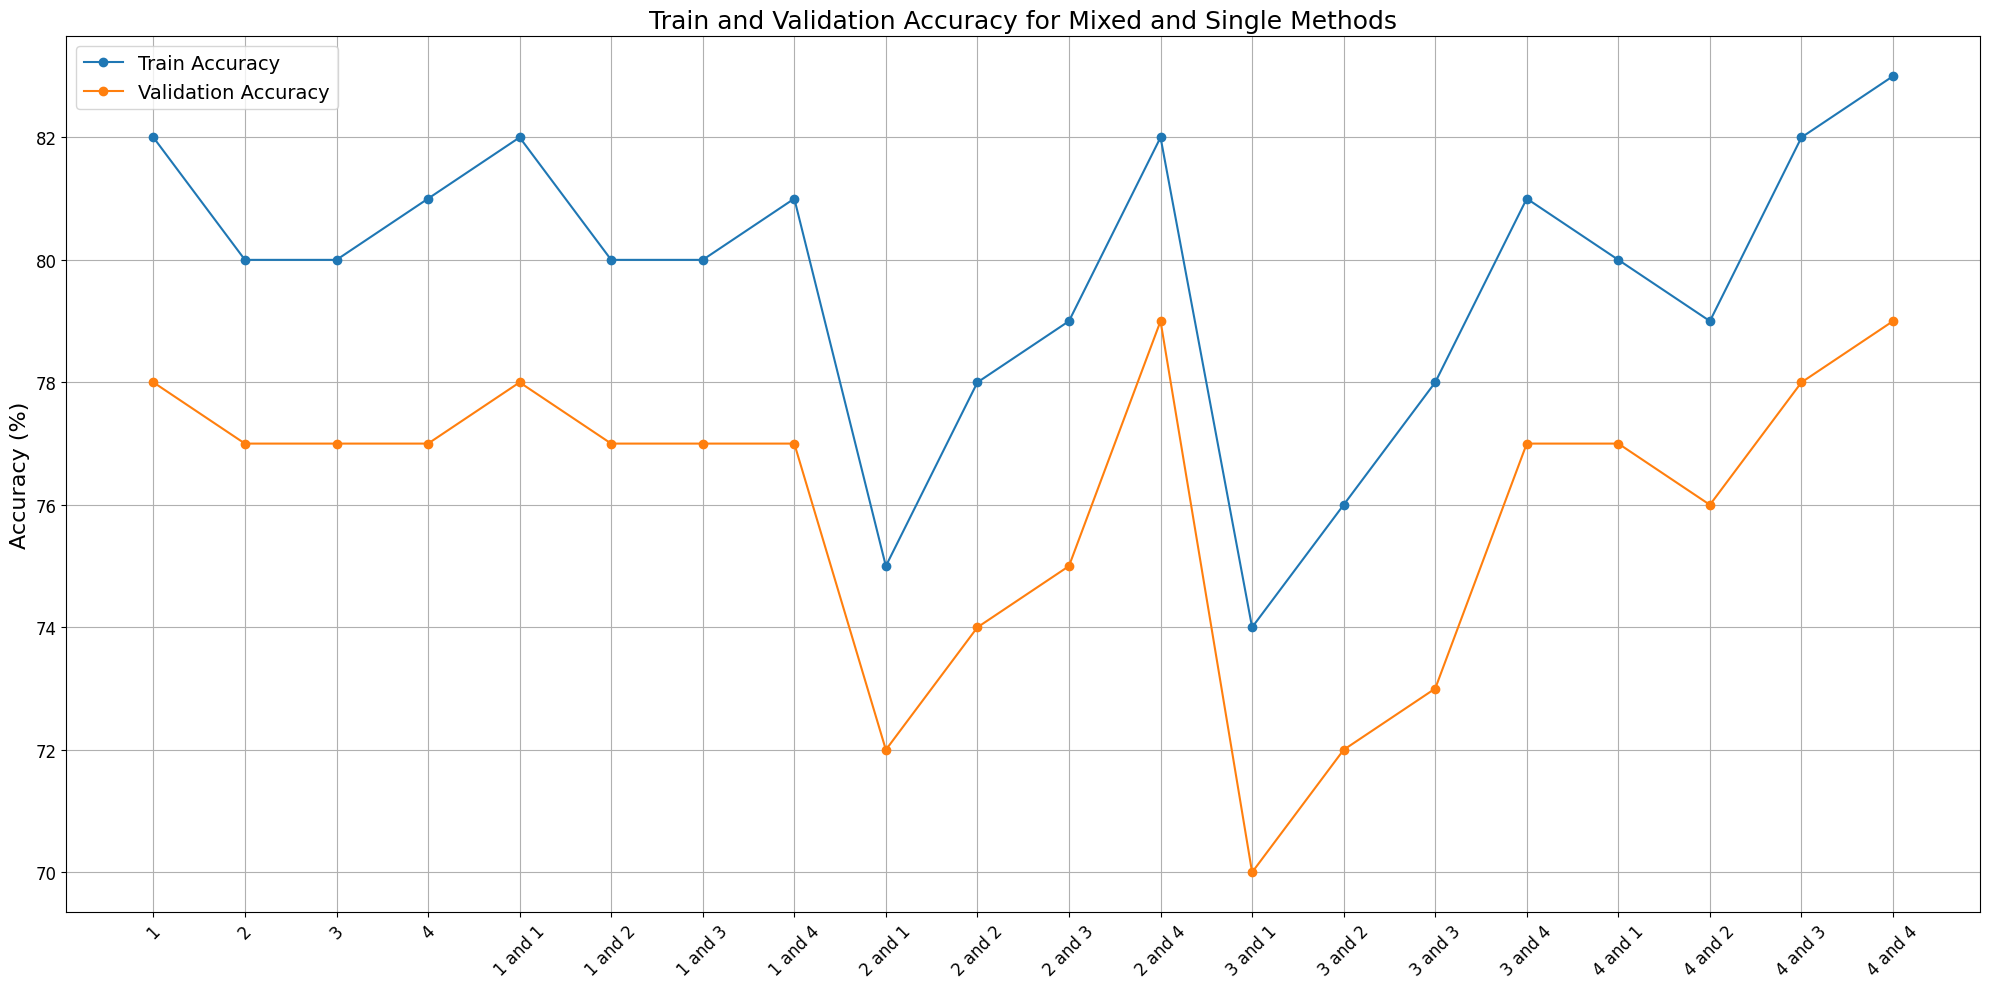

In [45]:
plt.figure(figsize=(20, 10))  # Large figure for clarity
plt.plot(df['trained_with'], df['train_accuracy'], marker='o', label='Train Accuracy')
plt.plot(df['trained_with'], df['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title("Train and Validation Accuracy for Mixed and Single Methods", fontsize=18)
plt.ylabel("Accuracy (%)", fontsize=16)
plt.xticks(df['trained_with'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


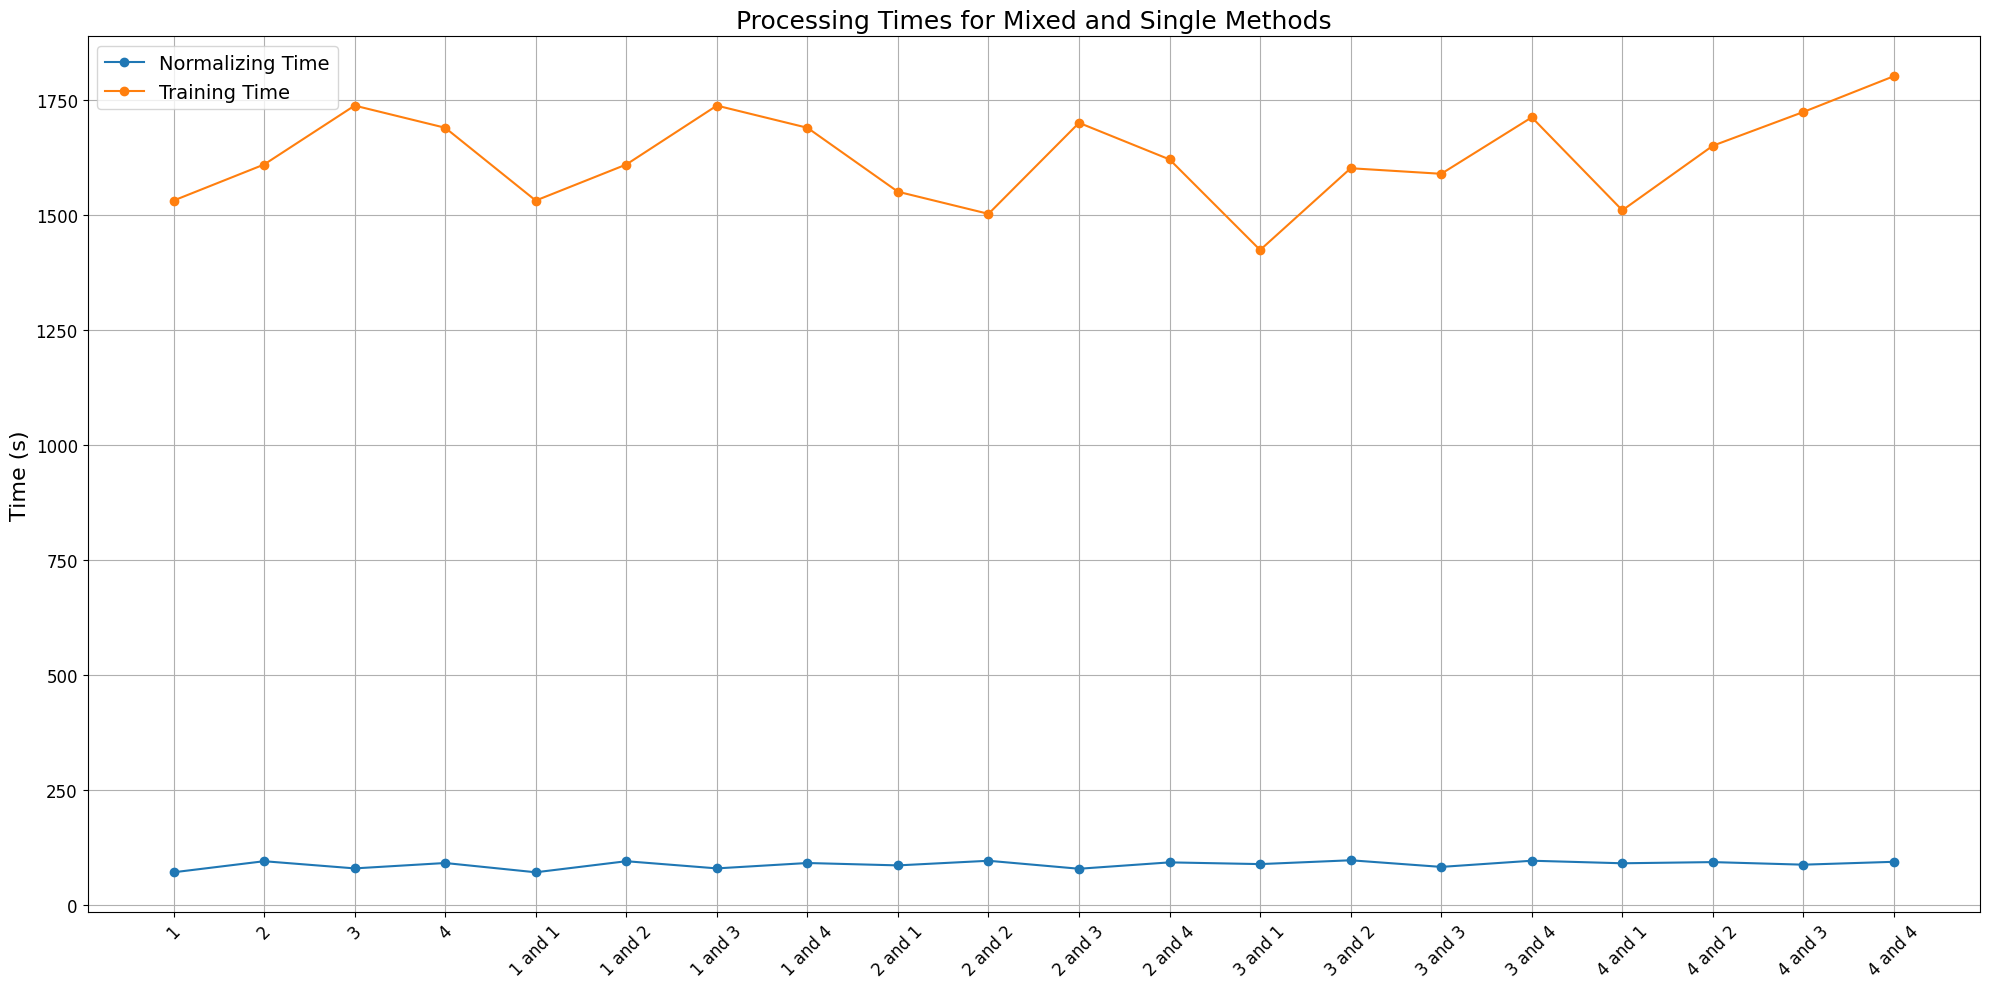

In [46]:
plt.figure(figsize=(20, 10))  # Large figure for clarity
plt.plot(df['trained_with'], df['normalizing_time'], marker='o', label='Normalizing Time')
plt.plot(df['trained_with'], df['training_time'], marker='o', label='Training Time')
plt.title("Processing Times for Mixed and Single Methods", fontsize=18)
plt.ylabel("Time (s)", fontsize=16)
plt.xticks(df['trained_with'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()
